# Setup

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import numpy as np
import scipy.signal

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Generate Data

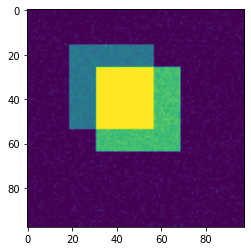

In [2]:
input = np.zeros((33, 33))
input[2, 5] = 0.4
input[12, 17] = 0.7

a,b= np.meshgrid(np.linspace(-1, 1, 66), np.linspace(-1, 1, 66))
rectangle = np.array(np.logical_and(np.abs(a) < 0.6, np.abs(b) < 0.6),dtype='float32') 

Img = scipy.signal.convolve2d(input, rectangle)
plt.imshow(Img)

IMG=np.stack((Img,) * 3, axis=-1)
IMG_T=torch.FloatTensor(IMG)
IMG_T=IMG_T.permute(2,1,0)
cleanImg=IMG_T.unsqueeze(0)


noisyImg = np.clip(Img + np.random.normal(scale=0.025, size=Img.shape), 0, 1).astype(np.float32) # adding noise from normal distribution

noisyImg1=np.stack((noisyImg,) * 3, axis=-1)
noisyImg1_T=torch.FloatTensor(noisyImg1)
noisyImg2_T=noisyImg1_T.permute(2,1,0)

noisyImg3_T=noisyImg2_T.unsqueeze(0)
plt.imshow(noisyImg3_T[0][0])


plt.imshow(noisyImg)

In [3]:
class Anet(nn.Module):
    def __init__(self, channel=8):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(3, self.channel, kernel_size=(97,1),padding=(48,0), padding_mode='replicate', bias=False, groups=1) #circular
        self.conv2 = nn.Conv2d(self.channel, 3, kernel_size=(1,97),padding=(0,48), padding_mode='replicate',bias=False, groups=1)
        #groups
    def forward(self, x):
        x1 =self.conv1(x)
        #x2 = F.relu(self.conv2(x1))
        out = self.conv2(x1)
        #out = F.relu(self.conv2(x2))
        return out
A_net = Anet() #.to(device)
mse = nn.MSELoss()

# Training Function

In [4]:
[12, 3, 97, 1]
[3, 12, 1, 97]



def my_outer(U, V):
  UV=torch.outer(U[0,0,:,0], V[0,0,0,:])
  for i in range(1, U.shape[0]):
    UV=UV+torch.outer(U[i,0,:,0], V[0,i,0,:])
  return UV


def my_singular(U, V):
  UV=my_outer(U, V)
  return np.array(torch.linalg.svdvals(UV).to('cpu').detach()) #.detach()

In [1]:
def plot_epoch(recon_np,noisy, Img):
  #if i % 50 == 0:
    fig = plt.figure(figsize=(7, 7))
    rows = 2
    columns = 2
    plt.subplot(rows, columns, 1)
    #recon_np = recon.squeeze(0).permute(1, 2, 0).to('cpu').detach().numpy()
    plt.imshow(recon_np, cmap='gray')
    plt.axis('off')
    plt.title("recon")
    plt.subplot(rows, columns, 2)
    plt.imshow(Img, cmap='gray')
    plt.axis('off')
    plt.title("Img")
    plt.subplot(rows, columns, 3)
    plt.imshow(noisyImg3_T[0][0], cmap='gray')
    plt.axis('off')
    plt.title("Img+Noise")
    plt.show()
    plt.show()

In [6]:
def recon(noisy, clean, alpha=0., iterations=5000, lr=1.e-2, gpu=False):
  import time

  cuda = torch.device('cuda') 

  A_net = Anet()
  x = torch.randn(1, 3, 98, 98)

  if gpu:
    A_net = A_net.to(cuda)
    x = x.to(cuda)
    noisy = noisy.to(cuda)
    clean = clean.to(cuda)

    #U=U.to(cuda)
    #V=V.to(cuda)
  
  optimizer = optim.SGD(A_net.parameters(), lr=lr)

  Loss_Rec, Loss_Reg, Loss, Error, S_values = [], [], [], [], []

  start = time.time()
  for i in tqdm(range(iterations)):

    recon = A_net(x)
    
    l2_norm = sum(p.pow(2.0).sum() for p in A_net.parameters()) #L2 norm of weights (p**2)
    U, V=[ p for p in A_net.parameters()]  

    loss_recon = mse(recon, noisy)
    Loss_Rec.append(loss_recon.item())
    
    loss_regu = alpha * l2_norm
    Loss_Reg.append(loss_regu.item())

    loss = loss_recon + loss_regu
    Loss.append(loss.item())

    error = mse(recon, clean)
    Error.append(error.item())
    
    S_values.append(my_singular(U, V))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if i % 500 == 0:
      plot_epoch(recon.squeeze(0).permute(1, 2, 0).to('cpu').detach().numpy(), noisy[0][0], Img)
  
  end = time.time()
  print(f"ending optimization in: {((end-start)/60):.3f} mins")

  return Loss_Rec, Loss_Reg, Loss, Error, S_values

# Reco for different Alpha

0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


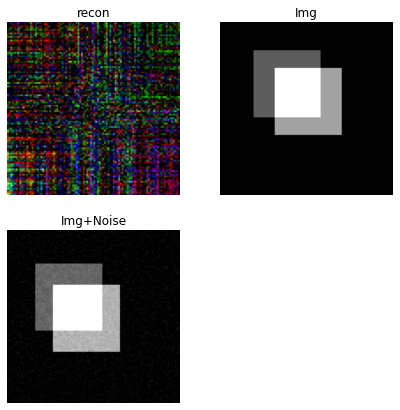

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


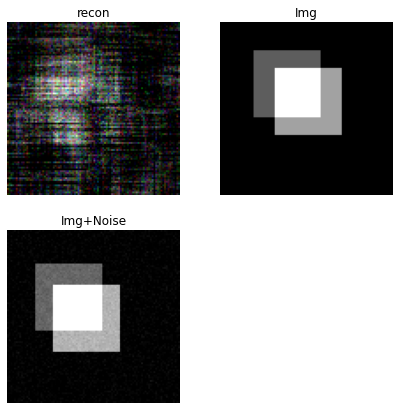

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


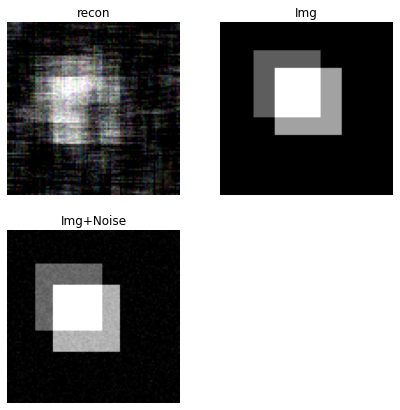

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


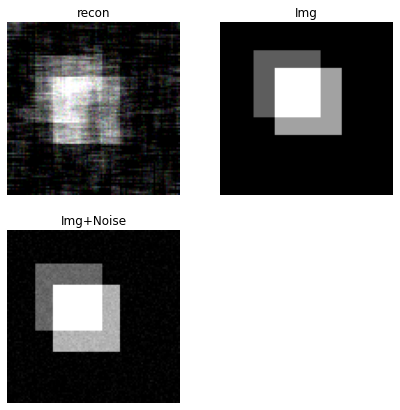

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


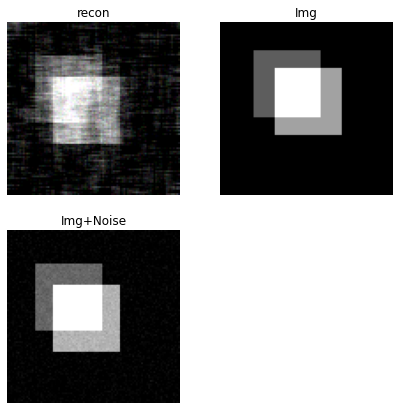

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


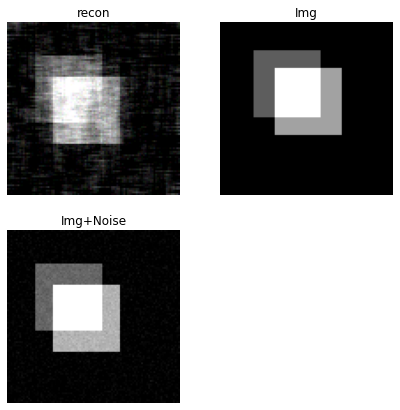

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


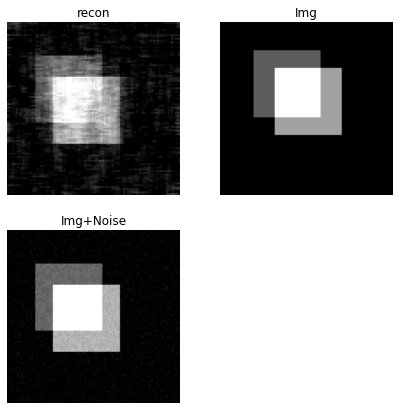

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


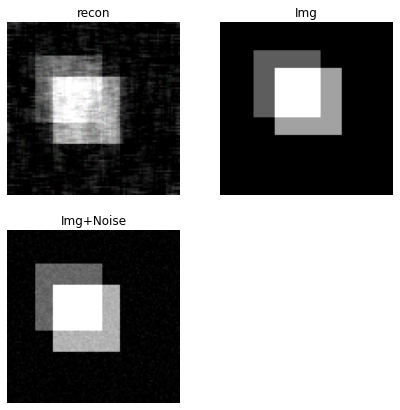

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


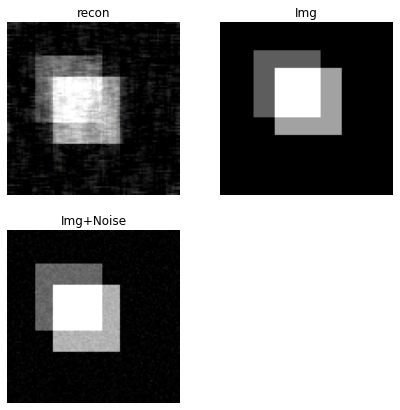

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


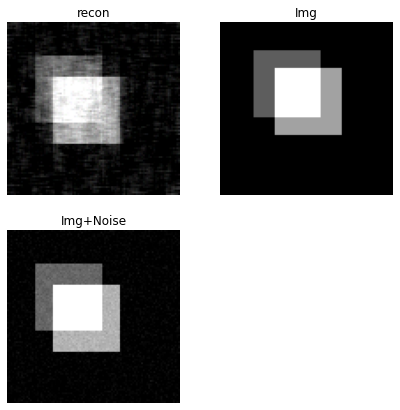

ending optimization in: 0.344 mins
0.016666666666666666


  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


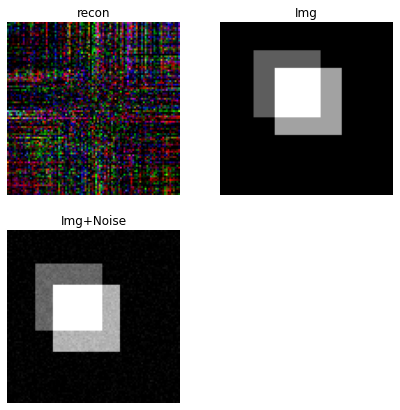

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


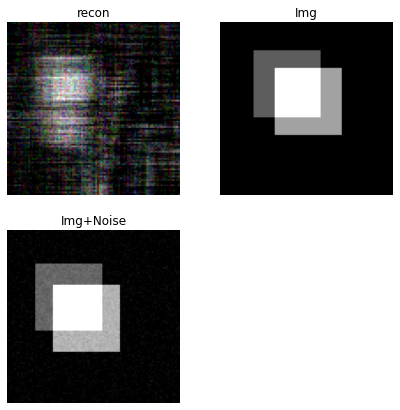

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


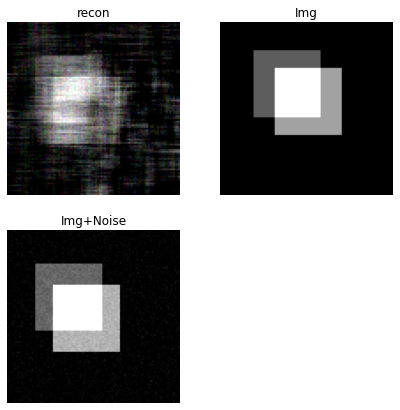

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


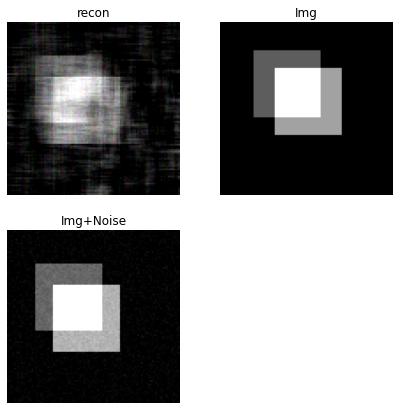

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


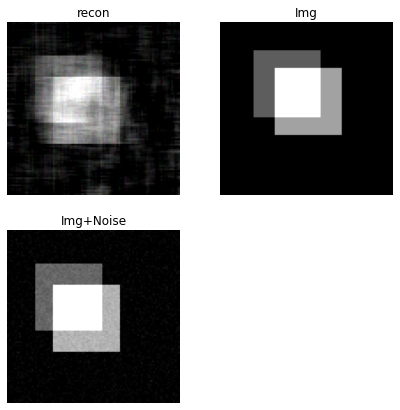

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


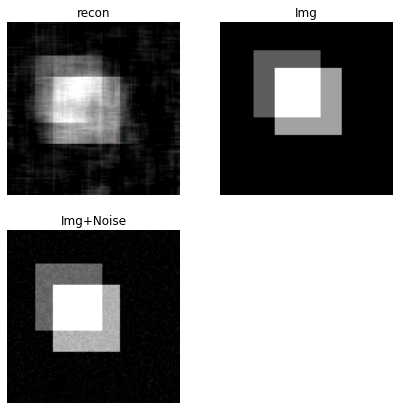

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


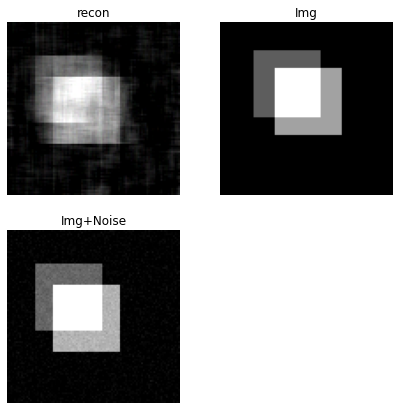

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


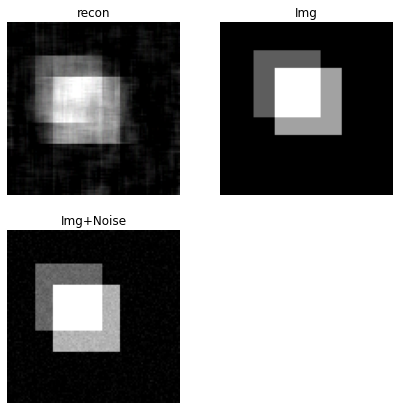

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


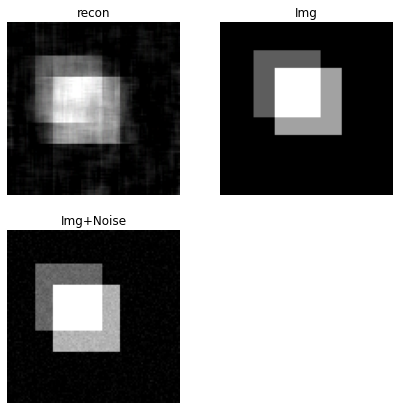

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


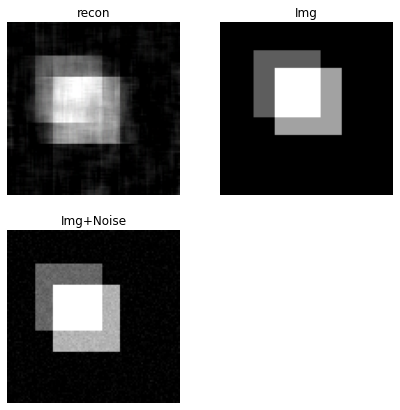

ending optimization in: 0.340 mins
0.03333333333333333


  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


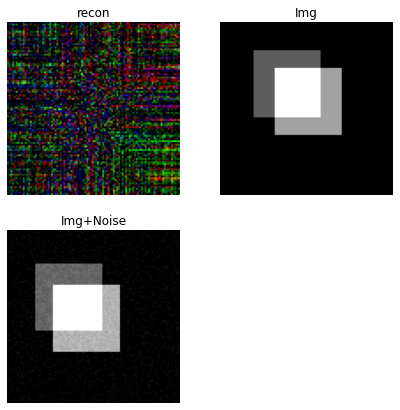

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


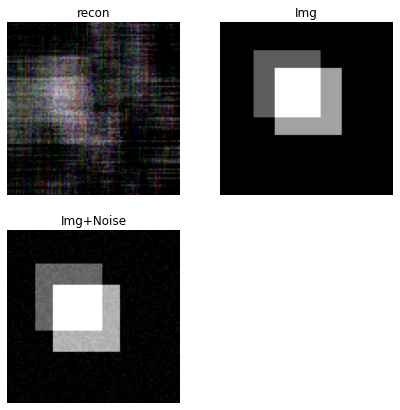

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


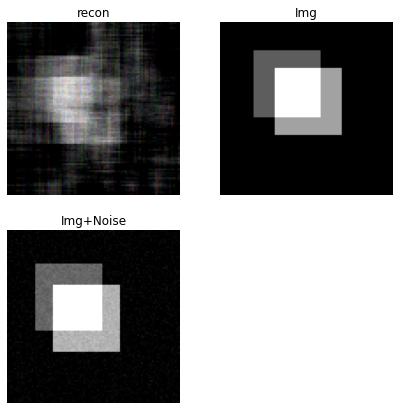

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


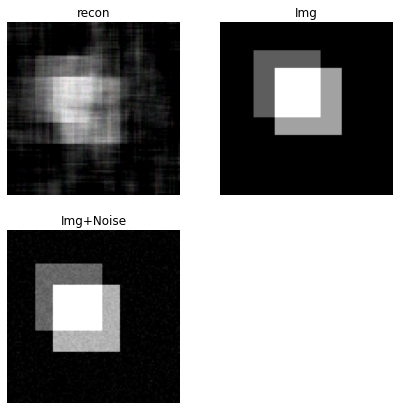

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


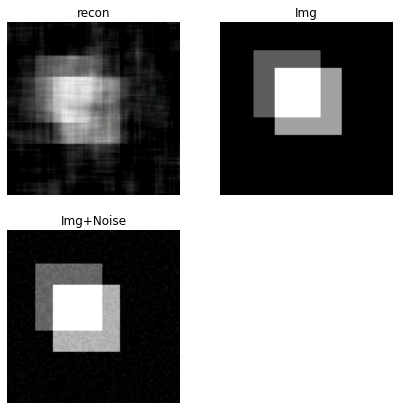

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


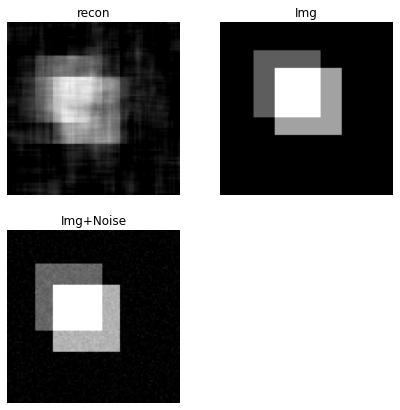

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


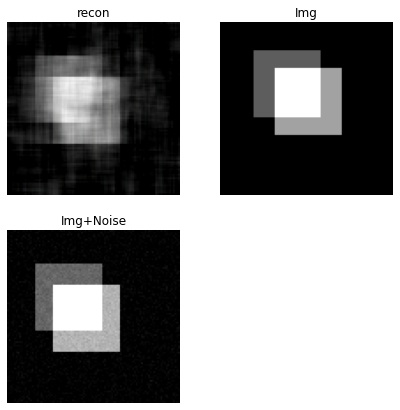

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


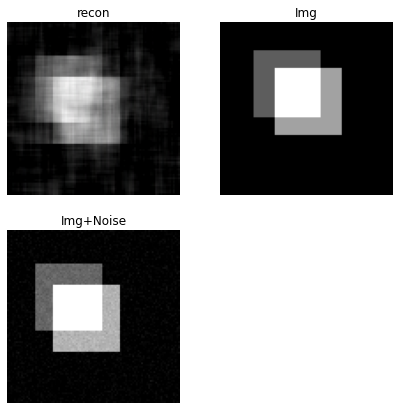

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


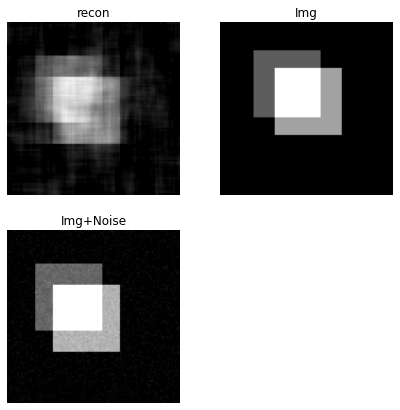

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


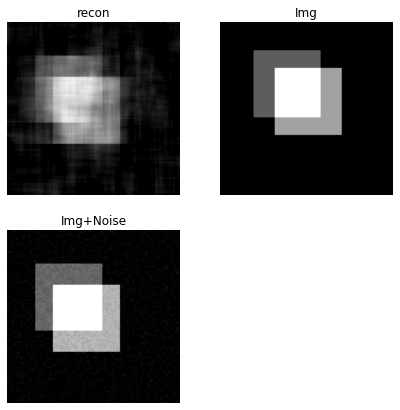

ending optimization in: 0.367 mins
0.05


  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


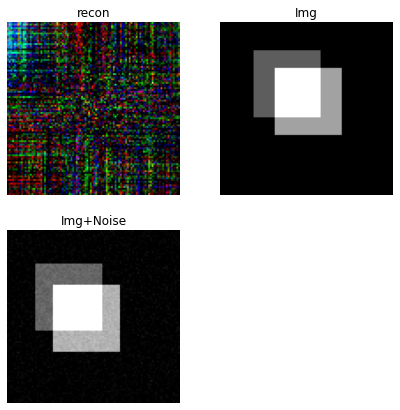

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


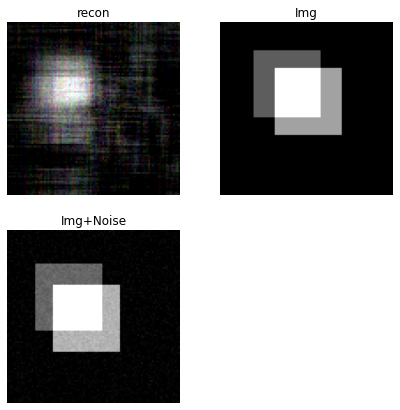

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


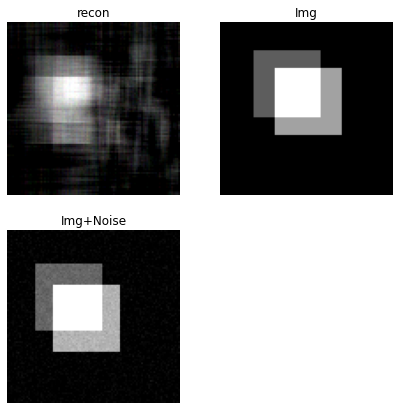

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


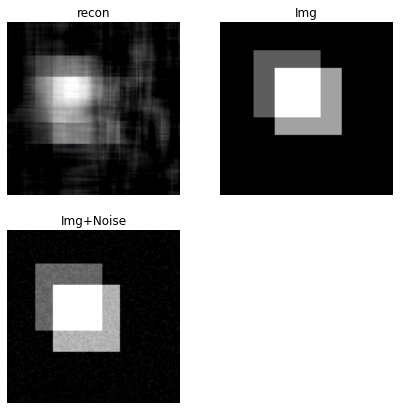

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


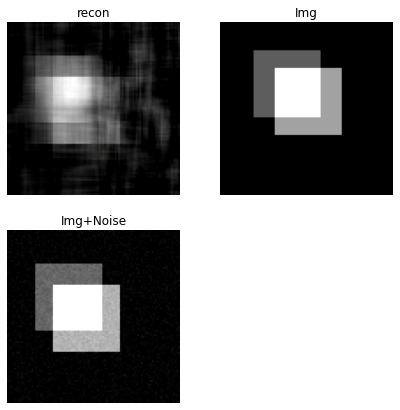

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


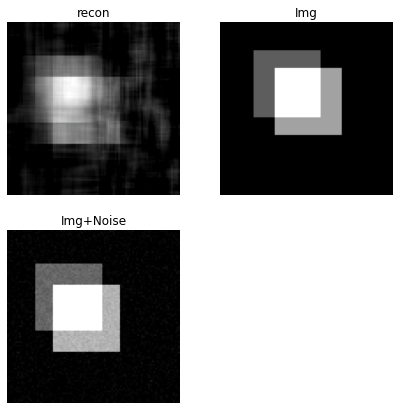

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


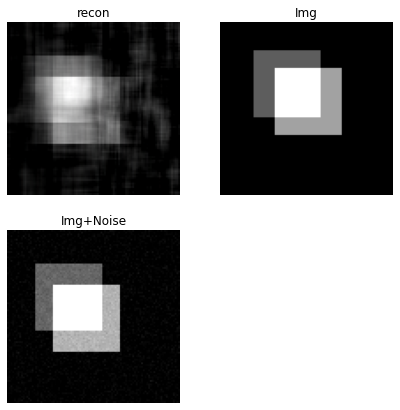

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


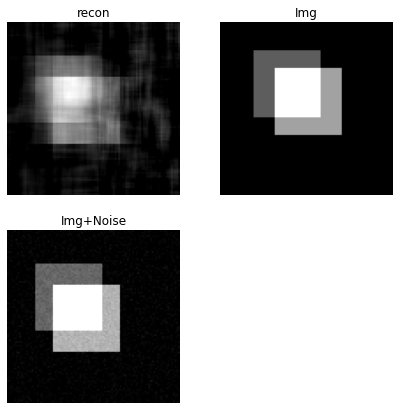

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


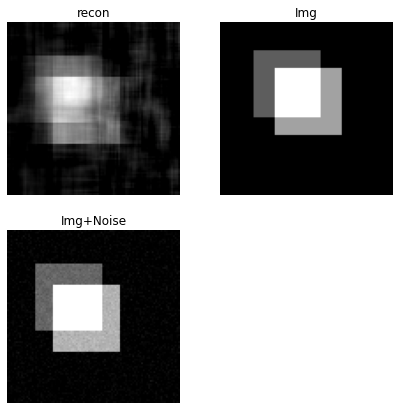

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


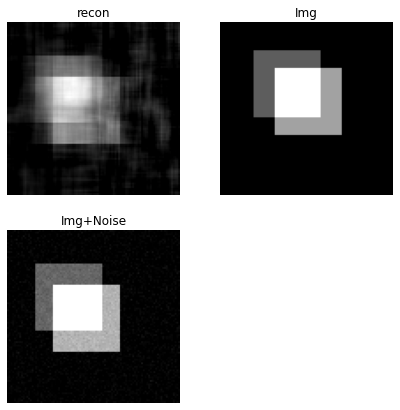

ending optimization in: 0.336 mins
0.06666666666666667


  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


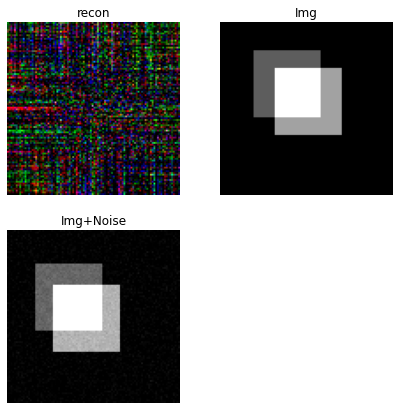

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


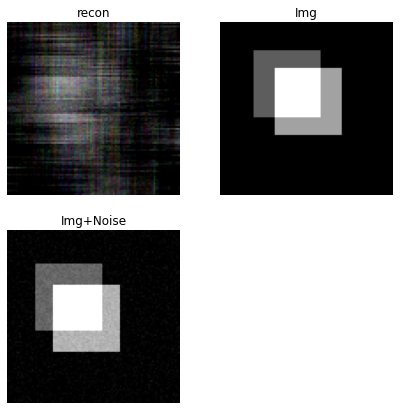

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


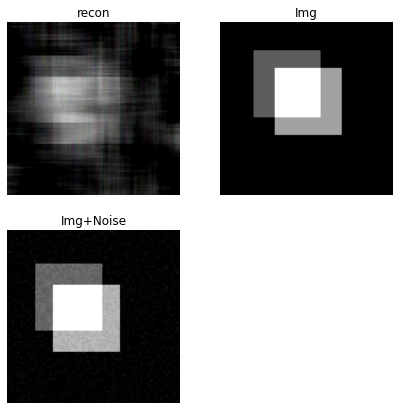

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


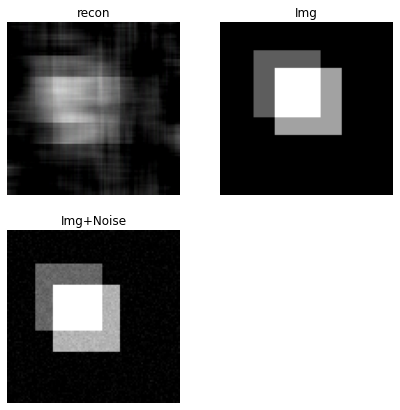

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


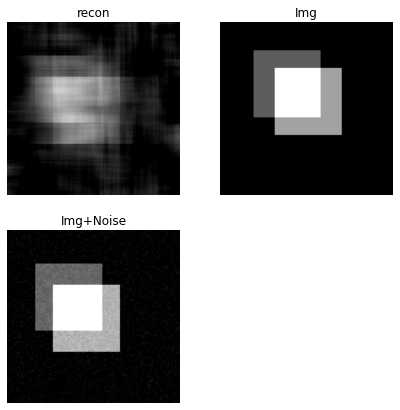

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


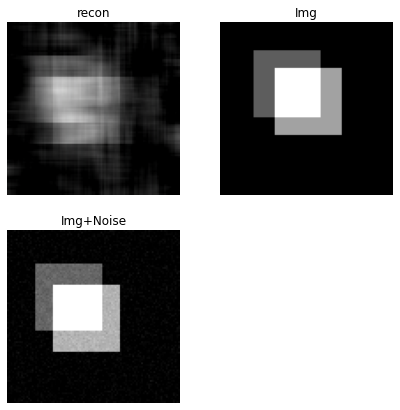

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


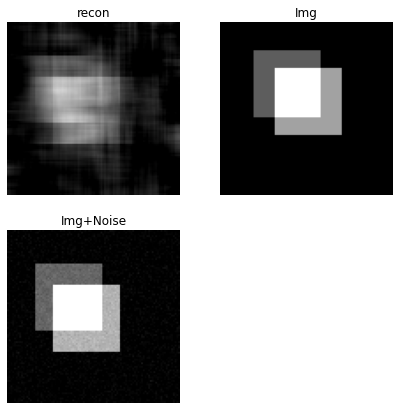

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


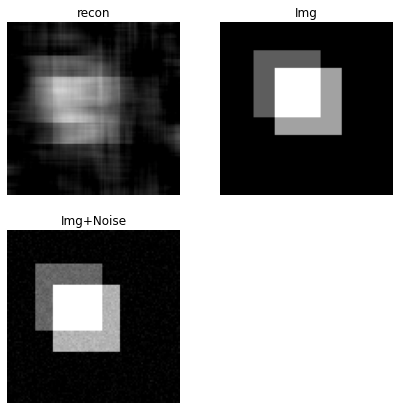

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


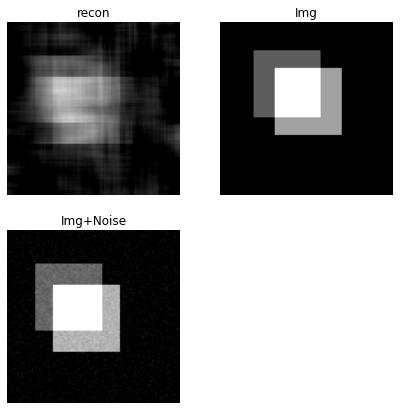

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


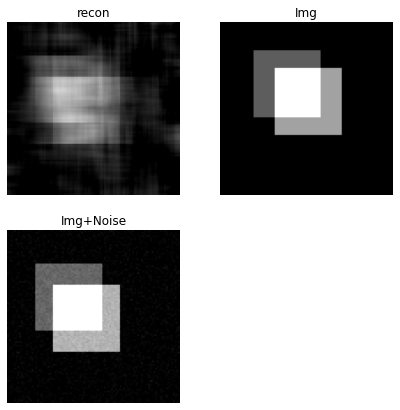

ending optimization in: 0.330 mins
0.08333333333333333


  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


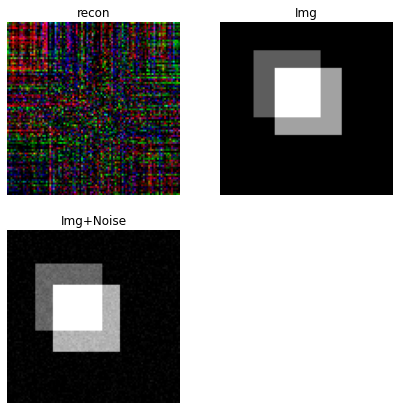

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


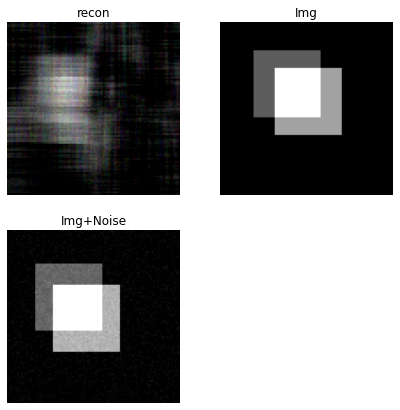

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


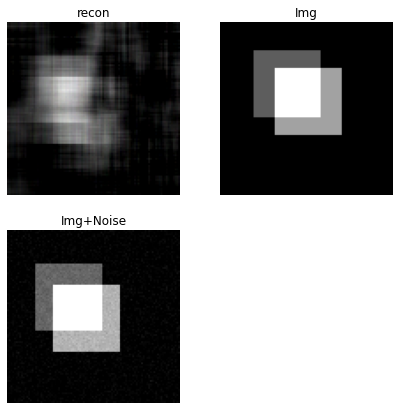

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


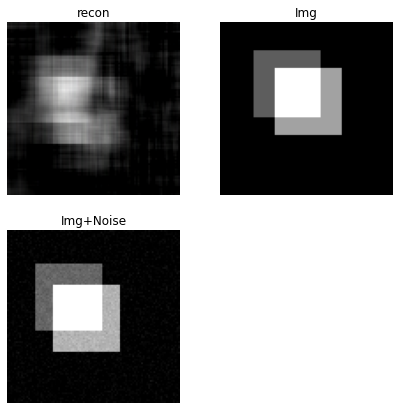

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


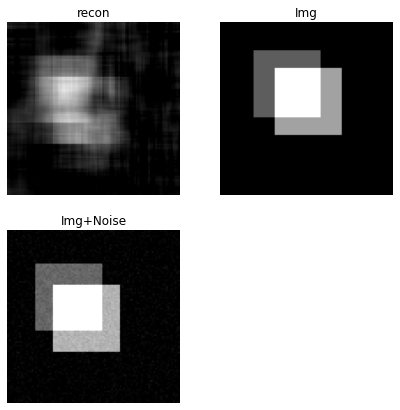

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


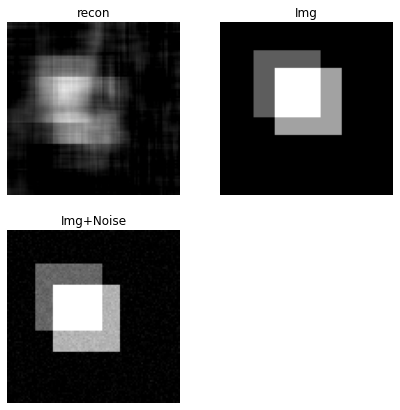

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


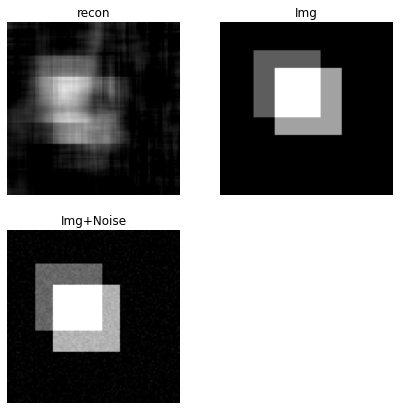

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


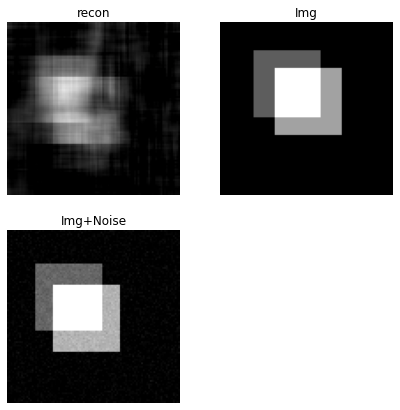

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


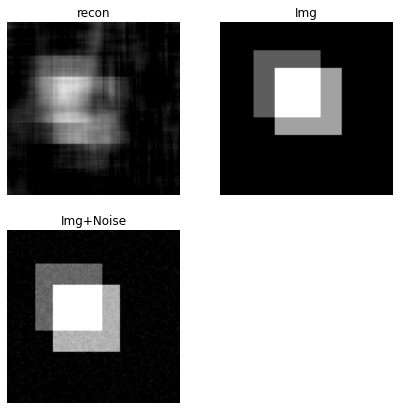

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


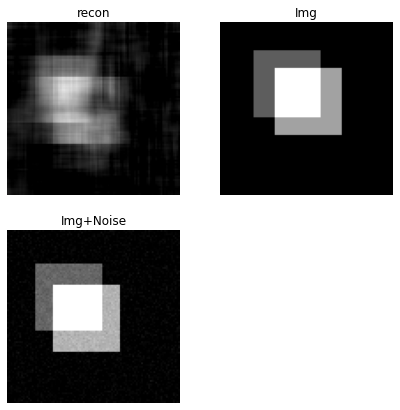

ending optimization in: 0.327 mins
0.1


  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


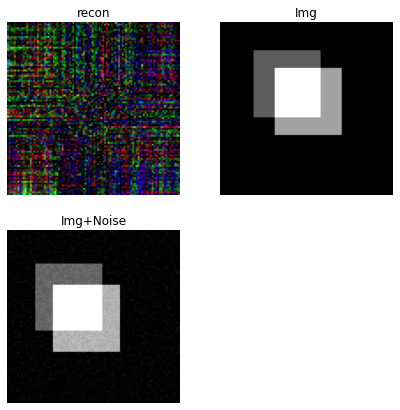

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


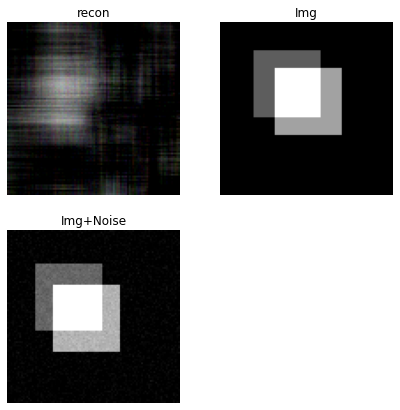

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


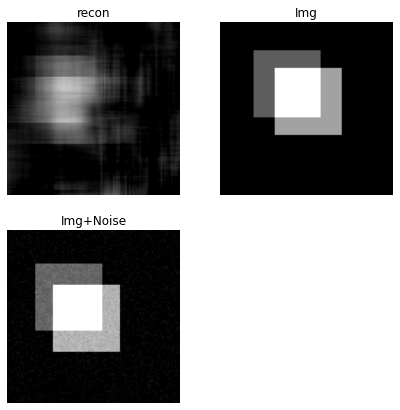

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


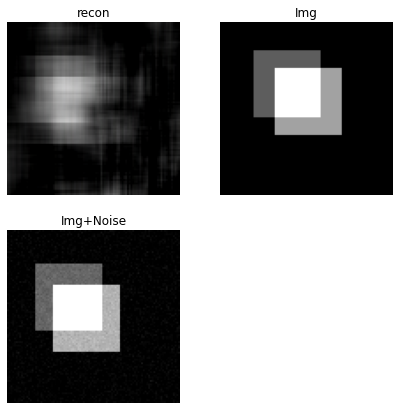

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


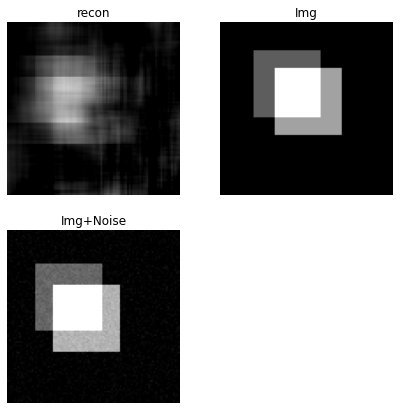

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


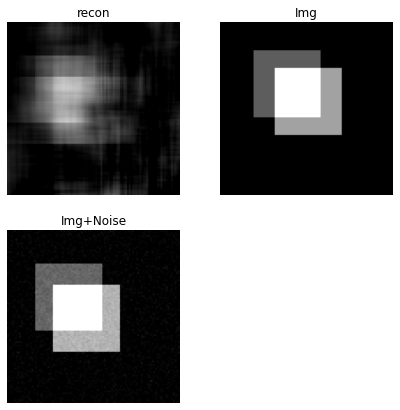

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


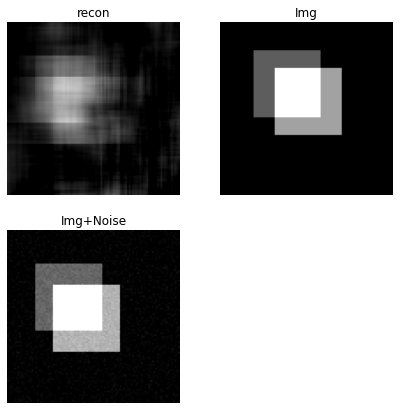

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


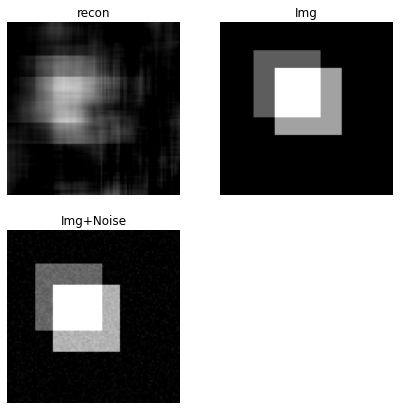

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


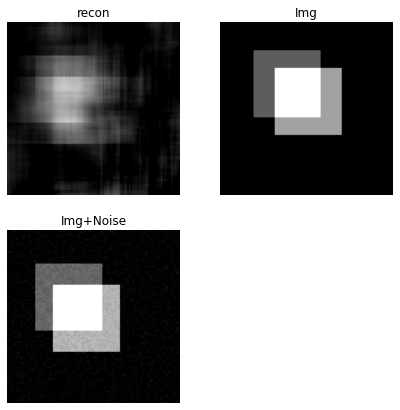

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


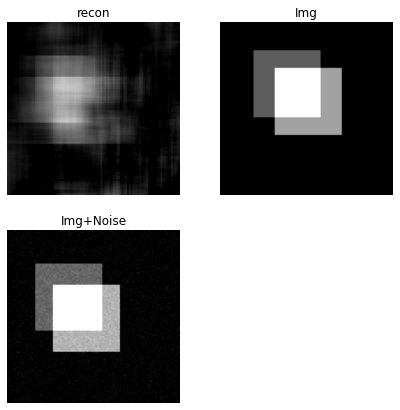

ending optimization in: 0.323 mins


In [7]:
Loss_Rec, Loss_Reg, Loss, Error, Sigma = [],[],[],[],[]

#Adapot alpha here!!!!
Alpha = np.linspace(0,0.1,7)

for alpha in Alpha:

  print(alpha)
  # lr 1.e-1 is too large
  # ->need more iterations ~ maybe 50000 are too many? 
  loss_rec, loss_reg, loss, error, s = recon(noisyImg3_T, cleanImg, gpu=True , alpha=alpha, iterations=5000)

  Loss_Rec.append(loss_rec)
  Loss_Reg.append(loss_reg)
  Loss.append(loss)
  Error.append(error)
  Sigma.append(s)

Loss_Rec=np.array(Loss_Rec)
Loss_Reg=np.array(Loss_Reg)
Loss=np.array(Loss)
Error=np.array(Error)
#UV_kernel=UV_kernel.cpu()
Sigma_arr=np.array(Sigma)


In [8]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/data/')

ModuleNotFoundError: No module named 'google'

In [ ]:
#save files
np.save("/home/sbazoobandi/data/Loss_Rec.npy", Loss_Rec)
np.save("/content/drive/My Drive/Loss_Reg.npy", Loss_Reg)
np.save("/content/drive/My Drive/Loss.npy",Loss)
np.save("/content/drive/My Drive/Error.npy", Error)
np.save("/content/drive/My Drive/Alpha.npy", Alpha)
np.save("/content/drive/My Drive/Sigma.npy", Sigma)

# Load files and Plotting

In [ ]:
Loss_Rec= np.load("/content/drive/My Drive/Loss_Rec.npy")
Loss_Reg= np.load("/content/drive/My Drive/Loss_Reg.npy")
Loss= np.load("/content/drive/My Drive/Loss.npy")
Error= np.load("/content/drive/My Drive/Error.npy")
Alpha= np.load("/content/drive/My Drive/Alpha.npy")
Sigma= np.load("/content/drive/My Drive/Sigma.npy")

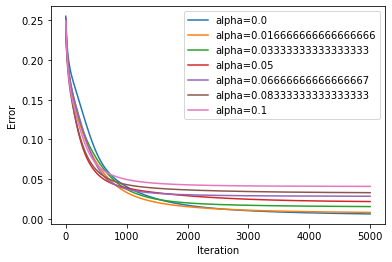

In [9]:
for i in range(Alpha.shape[0]):
  plt.plot(Error[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Error")

plt.legend()
plt.show()


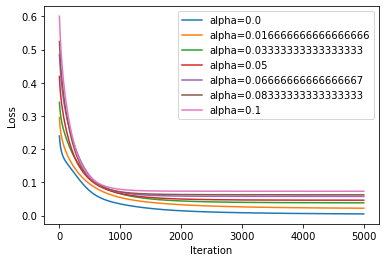

In [10]:
for i in range(Alpha.shape[0]):
  plt.plot(Loss[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.legend()
plt.show()


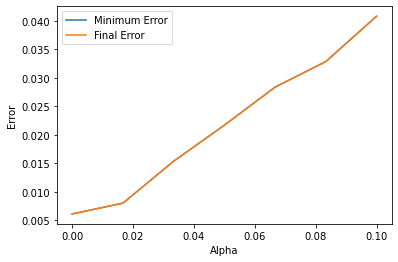

In [11]:

plt.plot(Alpha, np.min(Error, axis=1), label="Minimum Error")
plt.plot(Alpha, Error[:,-1], label="Final Error")

plt.xlabel("Alpha")
plt.ylabel("Error")

plt.legend()
plt.show()


  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


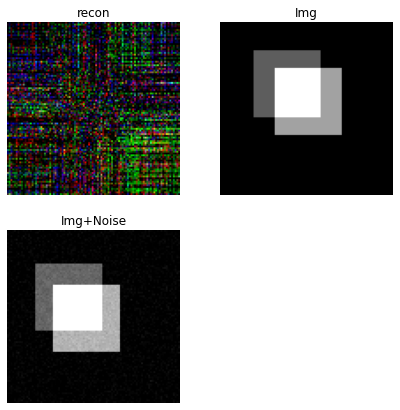

ending optimization in: 0.136 mins


In [12]:
Loss_Rec, Loss_Reg, Loss, Error, S_values = recon(noisyImg3_T, cleanImg, gpu=False , alpha=0.01, iterations=500)

In [13]:
len(S_values)

500

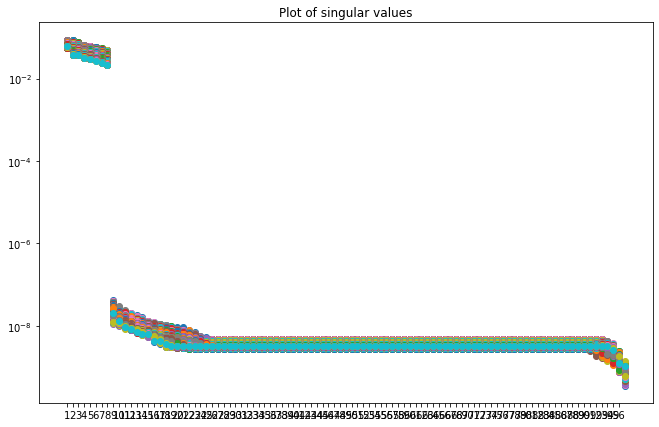

In [14]:
plt.figure(figsize= (11,7))
for i in range(len(S_values)):
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  plt.yscale("log")
  plt.title("Plot of singular values")

IndexError: list index out of range

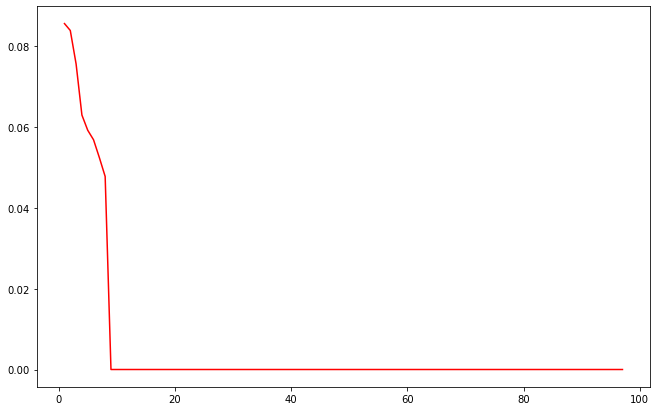

In [15]:
  plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "red" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[500], "blue" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[4999], "green" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  plt.yscale("log")
  plt.title("Plot of singular values")

Text(0.5, 1.0, 'Plot of singular values')

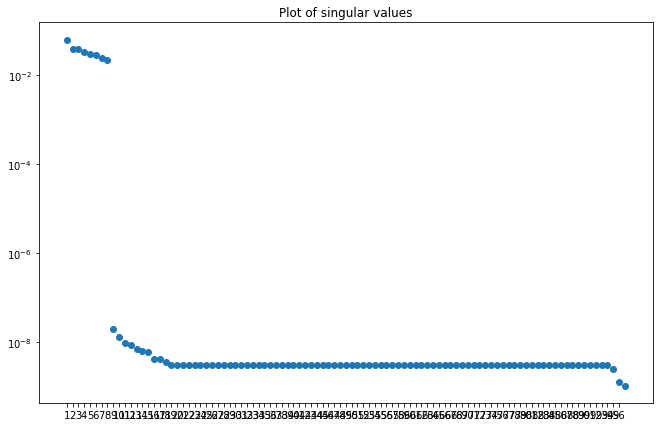

In [18]:
  plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
  #plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "v" )
  #plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[400], "*" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[499], "o" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  plt.yscale("log")
  plt.title("Plot of singular values")

In [20]:
A_net.eval()
with torch.no_grad():
#model.cpu
#image.cpu
 x = torch.randn(1, 3, 98, 98)
 out = A_net(x)

#U=U.squeeze(1)
#V=V.squeeze(0)
 U.shape
#U=U.cpu()
#V=V.cpu()

NameError: name 'U' is not defined

In [ ]:
U.shape

In [ ]:
[8, 3, 97, 1]
[3, 8, 1, 97]



def my_outer(U, V):
  UV=torch.outer(U[0,0,:,0], V[0,0,0,:])
  for i in range(1, U.shape[0]):
    UV=UV+torch.outer(U[i,0,:,0], V[0,i,0,:])
  return UV

In [ ]:
UV= my_outer(U, V)

In [ ]:
UV.shape

In [ ]:
plt.imshow(UV)

In [ ]:
A,S,B= np.linalg.svd(UV)

In [ ]:
DEFAULT_FIGSIZE = (8, 5)

plt.figure(figsize=DEFAULT_FIGSIZE)

plt.plot(np.arange(1, len(S) + 1), S, "o")
plt.xticks(np.arange(1, len(S) + 1))
plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
iter=np.arange(0,5000)

In [ ]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
for i in range(iter.shape[0]):
  #plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i],  label="iteration={}".format(iter[i]))
  plt.plot(S_values[i], label="iteration={}".format(iter[i]))
  #plt.xticks(np.arange(1, len(S_values[0] + 1)))
  #plt.yscale("log")
  plt.title("Plot of singular values")